# Active Learning - Comparando estratégias

Este notebook visa comparar as diversas estratégias de aprendizado ativo encontradas no documento do Burr Settles, disponível em: http://active-learning.net/.

Algumas das estratégias implementadas são:

- Amostra por incerteza
- Amostragem aleatória
- Consulta por comitê
- Aprendizado passivo
- Redução do erro esperado
- Expected Gradient Length

## O Framework

As estruturas do framework seguem o seguinte pipeline:
1. É usuário define quantas instâncias ele deseja através da variável *n_queries* (nota: quanto maior o número de instâncias, maior o custo computacional);

2. É definido um classificador através da função *which_classifier*, sendo os parâmentos:
    - **Classifier:** Define qual o classificador será utilizado no processo (atualmente só existe o KNN);
    
3. É definido o dataset através da função *which_dataset*:
    - **dataset:** Define o dataset a ser utilizado no framework(atualmente só possui o iris_dataset);
    - **n_split:** Define o tamanho das divisões feitas no dataset  (*cross-validation*).
    
4. A função *which_dataset* é responsável por retornar:
    - **X_raw:** Características dos dados do conjunto;
    - **y_raw:** Rótulos dos dados do conjunto;
    - **idx_data:** n listas (n = n_split) com a seguinte estrutura: [[train],[test]], nas listas train tendo os ids dos dados de treino e test os ids dos dados de teste. Assim, idx_data[i][j], tal que i = bag e j = treino(0) ou teste(1);
    
5. Após definir todo o ambiente, uma bateria de funções é executada, sendo essas as estratégias de amostragem do aprendizado ativo junto do dataset e do classificador escolhido.

Cada função de estratégia possui a mesma entrada e saída para padronização do framework, sendo elas:

#### Entrada
- **X_raw:** Características dos dados do conjunto;
- **y_raw:**  Rótulos dos dados do conjunto;
- **idx_data:** n listas (n = n_split) de ids do conjunto;
- **idx_bag:** Qual lista é desejado usar (idx_bag < n_splits);
- **classifier:** Qual classificador será utilizado (definido na função *which_classifier*);
- **init_size:**  Tamanho inicial da amostra (toda estratégia parte de um tamanho mínimo aleatório).

#### Saída:
- **score:** Acurácia do classificador + estratégia naquela bag;
- **time_elapsed:** Tempo de execução;
- **sample_size:** Quantidade de amostras utilizadas para treino daquele modelo;

# Comparando estratégias

- Amostra por incerteza
- Amostragem aleatória
- Consulta por comitê
- Aprendizado passivo
- Redução do erro esperado

In [6]:
import numpy as np
import pandas as pd
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [7]:
# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [8]:
from copy import deepcopy

In [9]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [10]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

In [11]:
from timeit import default_timer as timer

In [12]:
from sklearn.model_selection import ShuffleSplit

## Classificadores

### Algoritmos

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

### Conjunto de dados

In [14]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer

In [15]:
# Datasets OpenML

import openml
import os
openml.config.cache_directory = os.path.expanduser('./datasets/openML')

openml_list = openml.datasets.list_datasets()

datalist = pd.DataFrame.from_dict(openml_list, orient="index")
datalist = list(datalist[(datalist.NumberOfClasses.isnull() == False) & (datalist.NumberOfClasses != 0)]["did"])

## Amostra por incerteza

In [16]:
def uncertain_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, n_queries):
    
    from modAL.uncertainty import classifier_uncertainty
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    initial_idx = np.random.choice(range(len(idx_data[idx_bag][0])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][0][initial_idx]], y_raw[idx_data[idx_bag][0][initial_idx]]
    X_test, y_test = X_raw[idx_data[idx_bag][1]], y_raw[idx_data[idx_bag][1]]
    
    sample_size = sample_size + len(X_train)

    classifier.fit(X_train,y_train)

    learner = ActiveLearner (
        estimator=classifier,
        query_strategy=uncertainty_sampling
    )
    uncertain_sample_score = learner.score(X_test, y_test)

    performance_history.append(uncertain_sample_score)

    total_of_samples = 0
    while (total_of_samples != n_queries - 1):
        
        #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)
        
        idx = np.random.choice(range(len(idx_data[idx_bag][0])), size=init_size, replace=False)
        X_train, y_train = X_raw[idx_data[idx_bag][0][idx]], y_raw[idx_data[idx_bag][0][idx]]
        #print("WHILE", classifier_uncertainty(learner, X_train[0].reshape(1,-1)))
        if classifier_uncertainty(learner, X_train[0].reshape(1,-1)) > 0.2: #ASK04
            #print("IF", learner.score(X_test, y_test))
            sample_size = sample_size + len(X_train)
            learner.teach(X_train, y_train)
            uncertain_sample_score = learner.score(X_test, y_test)
            performance_history.append(uncertain_sample_score)
            #print("Uncertainty Sampling score: ", uncertain_sample_score)
            performance_history.append(uncertain_sample_score)    
        total_of_samples = total_of_samples + 1 #ASK05
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history, 
             "time_elapsed": time_elapsed,
             "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": 0}

## Amostragem aleatória

In [17]:
def random_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, n_queries):
        
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()

    for i in range(1,n_queries+1):

        #high = X_raw.shape[0] = qtd amostras no dataset
        training_indices = np.random.randint(low=0, high=len(X_raw[idx_data[idx_bag][0]]), size=k+i) #high = qtd elementos na bag
        sample_size = sample_size + len(training_indices)

        X_train = X_raw[idx_data[idx_bag][0][training_indices]] #ASK06
        y_train = y_raw[idx_data[idx_bag][0][training_indices]]

        X_test = np.delete(X_raw, idx_data[idx_bag][0][training_indices], axis=0)
        y_test = np.delete(y_raw, idx_data[idx_bag][0][training_indices], axis=0)

        classifier.fit(X_train, y_train)

        #pred = classifier.predict(X_test)
        #print("Random Sampling score: ", knn.score(X_test,y_test))
        performance_history.append(classifier.score(X_test,y_test))

        
    end = timer()
    time_elapsed = end - start

    return { "performance_history": performance_history, 
         "time_elapsed": time_elapsed,
         "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
         "Strategy": 1}

## Consulta por comitê

In [18]:
def query_by_committee(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, n_queries):

    from modAL.models import ActiveLearner, Committee
    from modAL.disagreement import vote_entropy_sampling

    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()


    for i in range(1,n_queries+1):

        learner_list = []

        for j in range(1,n_queries+1): # Loop para criação do comitê

            X_train, _, y_train, _ = train_test_split(X_raw[idx_data[idx_bag][0]], y_raw[idx_data[idx_bag][0]], train_size=0.03)
            sample_size = sample_size + len(X_train)
            
            # initializing learner
            learner = ActiveLearner(
                estimator=which_classifier(k, classifier = 'rfc'),
                query_strategy=uncertainty_sampling,
                X_training = X_train, y_training = y_train 
            )
            learner_list.append(learner)

        # assembling the committee
        committee = Committee(
            learner_list=learner_list,
            query_strategy=vote_entropy_sampling)

        X_pool, y_pool = X_raw[idx_data[idx_bag][0]], y_raw[idx_data[idx_bag][0]]

        # query by committee
        for idx in range(n_queries):
            query_idx, query_instance = committee.query(X_pool, n_instances = k+1)
            sample_size = sample_size + len(query_idx)
            committee.teach(
                X=X_pool[query_idx],
                y=y_pool[query_idx]
            )

            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
        performance_history.append(committee.score(X_pool, y_pool))

        #print(idx, n_queries, "Query by Committee: ", committee.score(X_pool, y_pool))

        
    end = timer()
    time_elapsed = end - start

    return { "performance_history": performance_history, 
         "time_elapsed": time_elapsed,
         "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
         "Strategy": 2}

## Exp Error Reduction

In [19]:
def exp_error_reduction(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, n_queries):

    from modAL.expected_error import expected_error_reduction
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    initial_idx = np.random.choice(range(len(idx_data[idx_bag][0])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][0][initial_idx]], y_raw[idx_data[idx_bag][0][initial_idx]]
    X_pool, y_pool = X_raw[idx_data[idx_bag][1]], y_raw[idx_data[idx_bag][1]]
    
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator=classifier,
        X_training=X_train, 
        y_training=y_train
    )
    exp_er_score = learner.score(X_pool, y_pool)
    performance_history.append(exp_er_score)

    total_of_samples = 0
    while (total_of_samples != n_queries):
        exp_error_idx = expected_error_reduction(learner, X_pool, 'binary', n_instances=init_size)[0]

        learner.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        sample_size = sample_size + init_size
        exp_er_score = learner.score(X_pool, y_pool)
    
        np.delete(X_pool, exp_error_idx, axis=0)
        np.delete(y_pool, exp_error_idx, axis=0)
        performance_history.append(exp_er_score)
        
        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history, 
             "time_elapsed": time_elapsed,
             "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": 3}

## Exp Model Change

In [20]:
def exp_model_change(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, n_queries):

    from modAL.expected_error import expected_error_reduction
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    initial_idx = np.random.choice(range(len(idx_data[idx_bag][0])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][0][initial_idx]], y_raw[idx_data[idx_bag][0][initial_idx]]
    X_pool, y_pool = X_raw[idx_data[idx_bag][1]], y_raw[idx_data[idx_bag][1]]
    
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator=classifier,
        X_training=X_train, 
        y_training=y_train
    )
    
#     performance_history.append(uncertain_sample_score)

    total_of_samples = 0
    while (total_of_samples != n_queries):
        exp_error_idx = np.random.choice(range(len(X_pool)), size=init_size, replace=False)
        aux = deepcopy(learner)

        aux.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        score_aux = aux.score(X_pool, y_pool)
        score_learner = learner.score(X_pool, y_pool)
        if score_aux > score_learner:
            #print(total_of_samples, " YES SCIENCE")
            learner = deepcopy(aux)
            sample_size = sample_size + init_size
        np.delete(X_pool, exp_error_idx, axis=0)
        np.delete(y_pool, exp_error_idx, axis=0)
        performance_history.append(learner.score(X_pool, y_pool))

        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history, 
             "time_elapsed": time_elapsed,
             "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": 4}

### Setup

In [21]:
def which_dataset(dataset = "iris", n_splits = 5):
    
    # Futuramente essa etapa será ajustada para receber qualquer dataset (ou lista com datasets)
    if (dataset == "iris"):
        data = load_iris()
        X_raw = data['data']
        y_raw = data['target']
    
    if (dataset == "wine"):
        data = load_wine()
        X_raw = data['data']
        y_raw = data['target']
        
    if (dataset == "digits"):
        data = load_digits()
        X_raw = data['data']
        y_raw = data['target']
        
    # cross validation bags
    data_cv = ShuffleSplit(n_splits= n_splits, test_size=0.3, random_state=0) #n_splits
    
    # extraindo ids do data_cv
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data

In [22]:
def which_oml_dataset(dataset_id, n_splits = 5):
    data = openml.datasets.get_dataset(dataset_id)
    
    X_raw, y_raw, categorical_indicator, attribute_names = data.get_data(
    dataset_format="array", target=data.default_target_attribute)
    
    le = preprocessing.LabelEncoder()
    le.fit(y_raw)
    y_raw = le.transform(y_raw)
    
    X_raw = np.nan_to_num(X_raw)
    
    data_cv = ShuffleSplit(n_splits= n_splits, test_size=0.3, random_state=0) #n_splits
    
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data, data.name

In [23]:
def which_classifier(parameters, classifier = 'knn'):
    
    if (classifier == 'knn'):
        return KNeighborsClassifier(parameters)
    if (classifier == 'rfc'):
        return RandomForestClassifier(n_estimators = parameters)

In [24]:
n_queries = 10 # cost
n_splits = 5 # number of bags cv
total_performance_history = []
k = 3 #parameter to knn classifier

idx_bag = 10

In [54]:
classifier = which_classifier(3, classifier = 'knn')

for dataset_id in datalist:
    X_raw, y_raw, idx_data, dataset_name = which_oml_dataset(dataset_id)
    for idx_bag in range(n_splits):
        print(dataset_name, " knn", " ", idx_bag, " ", n_splits, " uncertain_sampling")
        total_performance_history.append(uncertain_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, n_queries))

anneal  knn   0   5  uncertain_sampling
anneal  knn   1   5  uncertain_sampling
anneal  knn   2   5  uncertain_sampling
anneal  knn   3   5  uncertain_sampling
anneal  knn   4   5  uncertain_sampling
kr-vs-kp  knn   0   5  uncertain_sampling
kr-vs-kp  knn   1   5  uncertain_sampling
kr-vs-kp  knn   2   5  uncertain_sampling
kr-vs-kp  knn   3   5  uncertain_sampling
kr-vs-kp  knn   4   5  uncertain_sampling
labor  knn   0   5  uncertain_sampling
labor  knn   1   5  uncertain_sampling
labor  knn   2   5  uncertain_sampling
labor  knn   3   5  uncertain_sampling
labor  knn   4   5  uncertain_sampling
arrhythmia  knn   0   5  uncertain_sampling
arrhythmia  knn   1   5  uncertain_sampling
arrhythmia  knn   2   5  uncertain_sampling
arrhythmia  knn   3   5  uncertain_sampling
arrhythmia  knn   4   5  uncertain_sampling
letter  knn   0   5  uncertain_sampling
letter  knn   1   5  uncertain_sampling
letter  knn   2   5  uncertain_sampling
letter  knn   3   5  uncertain_sampling
letter  knn   4

splice  knn   2   5  uncertain_sampling
splice  knn   3   5  uncertain_sampling
splice  knn   4   5  uncertain_sampling
tae  knn   0   5  uncertain_sampling
tae  knn   1   5  uncertain_sampling
tae  knn   2   5  uncertain_sampling
tae  knn   3   5  uncertain_sampling
tae  knn   4   5  uncertain_sampling
heart-c  knn   0   5  uncertain_sampling
heart-c  knn   1   5  uncertain_sampling
heart-c  knn   2   5  uncertain_sampling
heart-c  knn   3   5  uncertain_sampling
heart-c  knn   4   5  uncertain_sampling
tic-tac-toe  knn   0   5  uncertain_sampling
tic-tac-toe  knn   1   5  uncertain_sampling
tic-tac-toe  knn   2   5  uncertain_sampling
tic-tac-toe  knn   3   5  uncertain_sampling
tic-tac-toe  knn   4   5  uncertain_sampling
heart-h  knn   0   5  uncertain_sampling
heart-h  knn   1   5  uncertain_sampling
heart-h  knn   2   5  uncertain_sampling
heart-h  knn   3   5  uncertain_sampling
heart-h  knn   4   5  uncertain_sampling
trains  knn   0   5  uncertain_sampling
trains  knn   1   5 

KeyboardInterrupt: 

In [ ]:
from tqdm.notebook import tqdm, trange
p_bar = tqdm(datalist)
for dataset_id in p_bar:
    X_raw, y_raw, idx_data, dataset_name = which_oml_dataset(dataset_id)
    p_bar.set_description(f'"{dataset_name}"')

  0%|          | 0/1356 [00:00<?, ?it/s]

In [18]:
datasets = ["iris", "wine", "digits"]
classifiers = ["knn", "rfc"]

for ds in datasets:
    for cls in classifiers:
        classifier = which_classifier(3, classifier = cls)
        X_raw, y_raw, idx_data = which_dataset(ds)

        #para cada i em idx_bag ("n_splits") (1 a 5)
        for idx_bag in range(n_splits):
            print(ds, " ", cls, " ", idx_bag, " ", n_splits, " uncertain_sampling")
            total_performance_history.append(uncertain_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, n_queries))
        for idx_bag in range(n_splits):
            print(ds, " ", cls, " ", idx_bag, " ", n_splits, " random sampling")
            total_performance_history.append(random_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, n_queries))
        for idx_bag in range(n_splits):
            print(ds, " ", cls, " ", idx_bag, " ", n_splits, " query_by_committee")
            total_performance_history.append(query_by_committee(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, n_queries))
        for idx_bag in range(n_splits):
            print(ds, " ", cls, " ", idx_bag, " ", n_splits, " exp error reduction")
            total_performance_history.append(exp_error_reduction(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, n_queries))
        for idx_bag in range(n_splits):
            print(ds, " ", cls, " ", idx_bag, " ", n_splits, " exp model change")
            total_performance_history.append(exp_model_change(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, n_queries))

iris   knn   0   5  uncertain_sampling
iris   knn   1   5  uncertain_sampling
iris   knn   2   5  uncertain_sampling
iris   knn   3   5  uncertain_sampling
iris   knn   4   5  uncertain_sampling
iris   knn   0   5  random sampling
iris   knn   1   5  random sampling
iris   knn   2   5  random sampling
iris   knn   3   5  random sampling
iris   knn   4   5  random sampling
iris   knn   0   5  query_by_committee
iris   knn   1   5  query_by_committee
iris   knn   2   5  query_by_committee
iris   knn   3   5  query_by_committee
iris   knn   4   5  query_by_committee
iris   knn   0   5  exp error reduction
iris   knn   1   5  exp error reduction
iris   knn   2   5  exp error reduction
iris   knn   3   5  exp error reduction
iris   knn   4   5  exp error reduction
iris   knn   0   5  exp model change
iris   knn   1   5  exp model change
iris   knn   2   5  exp model change
iris   knn   3   5  exp model change
iris   knn   4   5  exp model change
iris   rfc   0   5  uncertain_sampling
iris  

In [51]:
total_performance_history

[{'performance_history': [0.4],
  'time_elapsed': 0.05164477399921452,
  'sample_size': 3,
  'Strategy': 0},
 {'performance_history': [0.37777777777777777],
  'time_elapsed': 0.02088340599948424,
  'sample_size': 3,
  'Strategy': 0},
 {'performance_history': [0.35555555555555557,
   0.35555555555555557,
   0.35555555555555557,
   0.6222222222222222,
   0.6222222222222222,
   0.9111111111111111,
   0.9111111111111111,
   1.0,
   1.0,
   1.0,
   1.0],
  'time_elapsed': 0.07590293900011602,
  'sample_size': 18,
  'Strategy': 0},
 {'performance_history': [0.37777777777777777,
   0.37777777777777777,
   0.37777777777777777,
   0.6444444444444445,
   0.6444444444444445,
   0.7555555555555555,
   0.7555555555555555],
  'time_elapsed': 0.02854137600024842,
  'sample_size': 12,
  'Strategy': 0},
 {'performance_history': [0.35555555555555557,
   0.24444444444444444,
   0.24444444444444444],
  'time_elapsed': 0.01830579499983287,
  'sample_size': 6,
  'Strategy': 0}]

In [20]:
df = pd.DataFrame.from_dict(total_performance_history)

In [21]:
df = df.explode('performance_history')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1598 entries, 0 to 149
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   performance_history  1598 non-null   object 
 1   time_elapsed         1598 non-null   float64
 2   sample_size          1598 non-null   int64  
 3   Strategy             1598 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 62.4+ KB


## Visualization

In [23]:
#  https://seaborn.pydata.org/examples/scatterplot_sizes.html
import seaborn as sns

In [24]:
g = sns.relplot(
    data= df,
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=3), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

ValueError: The palette list has the wrong number of colors.

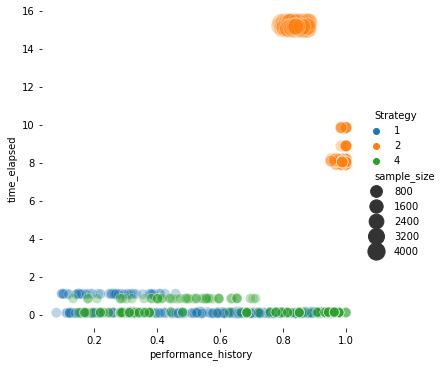

In [25]:
g = sns.relplot(
    data= df[(df.Strategy != 0) & (df.Strategy != 3)],
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=3), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

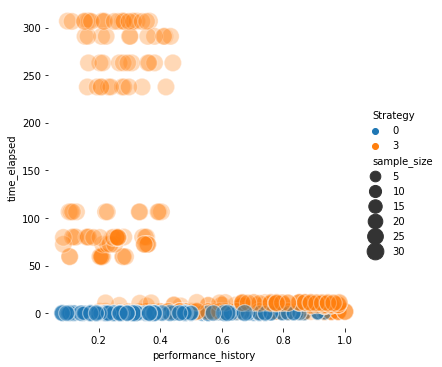

In [26]:
g = sns.relplot(
    data= df[(df.Strategy == 0) | (df.Strategy == 3)],
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=2), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)